In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
# plt.style.use('/fred/oz022/pmm_pulsar/state_space_pulsar_inference/state_space_inference/meyers_latex.mplstyle')
rcParams['text.latex.preamble'] = r'\newcommand{\mathdefault}[1][]{}'
import baboo
plt.style.use(baboo.__path__[0] + '/baboo.mplstyle')
import seaborn as sns
# import baboo stuff
from baboo.simulation import two_component_fake_data
from baboo.models import OneComponentModel, TwoComponentModel
from baboo.sample import KalmanLikelihoodOneComponent, KalmanLikelihood
import bilby
from corner import corner


Bad key "hist.edgecolor" on line 47 in
/fred/oz022/pmm_pulsar/baboo_source/baboo/baboo/baboo.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "hatch.alpha" on line 49 in
/fred/oz022/pmm_pulsar/baboo_source/baboo/baboo/baboo.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


# Simulate Frequencies

In this notebook we show you how to simulate a set of frequencies directly. We'll save simulating ToA's for a separate notebook.

In [2]:
# original parameters
N_c = -1e-11
N_s = -1e-14
tau_c = 1e6
tau_s = 3e6
R_c=1e-18
R_s=1e-18

# derived parameters [these are self-consistent with the ones above, put in by hand]
r = 3
tau = 7.5e5
omgc_dot = (N_c*tau_c + N_s * tau_s) / (tau_c + tau_s)
lag = -7.5e-6
F0_c = 10.
F0_s = F0_c - lag
Qc = 1e-21
Qs = 1e-21

# how much data to create?
Ndays = 3650
Nmeasurements = 1200

In [3]:
# non-uniform spacing, so simulate each hour
orig_times = np.arange(Ndays * 24) / 24 
# indexes for times at which we make measurements. So pick "Nmeasurements"
idxs = np.sort(np.random.choice(orig_times*24, size=Nmeasurements, replace=False)).astype(int) 
# simulate fake data
newstates = two_component_fake_data(orig_times*86400, Omgc_start=F0_c,
                                    xi_c=np.sqrt(Qc), xi_s=np.sqrt(Qs),
                                    N_c=N_c, N_s=N_s, tau_c=tau_c,
                                    tau_s=tau_s, R_c=R_c, R_s=R_s)
newfreqs = newstates[idxs, 0]
newtimes = orig_times[idxs]

In [4]:
# create model
newerrs = 1e-18 * np.ones(newtimes.size)

# covariance matrix
mycov = np.asarray([np.eye(1) * freq_err for freq_err in newerrs]).T

# Design matrix should be a row vector
design = np.asarray([1., 0.]).reshape(1, 2)



# create model class
two_component_model = TwoComponentModel(np.array(newfreqs).astype(float).reshape((np.size(newtimes), 1)),
                                        mycov, design, 86400.*np.array(newtimes).astype(float))

# create likelihood class
likelihood = KalmanLikelihood(two_component_model)

In [5]:
# For now, narrow in around values for starting frequency and spindown using a linear fit
# However, allow for a very wide prior range around the estimated values.
p, V = np.polyfit((np.array(newtimes).astype(float) - newtimes[0])*86400, np.array(newfreqs).astype(float), 1, cov=True, w=1/np.array(np.sqrt(newerrs)).astype(float))
F1_est = p[0]
F1err = 10000 * np.sqrt(V[0,0])
F0_est = p[1]
F0err = 10000 * np.sqrt(V[1,1])
print(F1_est, F1err)


# create priors for model using Bilby inference software
priors = bilby.core.prior.PriorDict()
priors['relax_ratio'] = bilby.core.prior.LogUniform(minimum=1e-2, maximum=1e2,name='relax_ratio', latex_label='$\\frac{\\tau_s}{\\tau_c}$')
priors['reduced_relax'] = bilby.core.prior.LogUniform(minimum=1e-8, maximum=1e-5, name='reduced_relax', latex_label='$\\frac{\\tau_c + \\tau_s}{\\tau_c\\tau_s}$')
priors['Qc'] = bilby.core.prior.LogUniform(minimum=1e-30, maximum=1e-16, name='Qc', latex_label='$Q_c$')
priors['Qs'] = bilby.core.prior.LogUniform(minimum=1e-30, maximum=1e-16, name='Qs', latex_label='$Q_s$')
priors['lag'] = bilby.core.prior.Uniform(minimum=-1e-3, maximum=0, name='lag', latex_label='$\\Omega_c - \\Omega_s$')

# See fits above
priors['omegac_dot'] = bilby.core.prior.Uniform(minimum=F1_est - F1err, maximum=F1_est + F1err, name='omegac_dot', latex_label='$\\langle \\dot{\\Omega}_c \\rangle$')
priors['omgc_0'] = bilby.core.prior.Uniform(F0_est-F0err, F0_est+F0err, name='omgc_0', latex_label='$\\Omega_{\\rm{c}, 0}$')

# EFAC and EQUAd not used for now -- we know what they are for this simulation
priors['EFAC'] = bilby.core.prior.DeltaFunction(1, name='EFAC',
        latex_label='EFAC')
priors['EQUAD'] = bilby.core.prior.DeltaFunction(0, name='EQUAD',
        latex_label='EQUAD')

-2.509618877227386e-12 3.007576429355349e-13


In [6]:
# Sample
# Use a small number of livepoints now so it finishes quickly -- in the future we should use more.
# NOTE: You will likely see some warnings for numba -- I have tried to fix these, but they are still
# showing up. They don't cause issues at the moment.
result3 = bilby.run_sampler(likelihood, priors, sampler='dynesty', walks=10, npoints=100, resume=False, sample='rwalk_dynesty', bound='single', label='gn_noise_alt', outdir='general_noise_model')

11:05 bilby INFO    : Running for label 'gn_noise_alt', output will be saved to 'general_noise_model'
11:05 bilby WARNING : Parameter omgs_0 has no default prior and is set to None, this will not be sampled and may cause an error.
11:05 bilby INFO    : Search parameters:
11:05 bilby INFO    :   relax_ratio = LogUniform(minimum=0.01, maximum=100.0, name='relax_ratio', latex_label='$\\frac{\\tau_s}{\\tau_c}$', unit=None, boundary=None)
11:05 bilby INFO    :   reduced_relax = LogUniform(minimum=1e-08, maximum=1e-05, name='reduced_relax', latex_label='$\\frac{\\tau_c + \\tau_s}{\\tau_c\\tau_s}$', unit=None, boundary=None)
11:05 bilby INFO    :   Qc = LogUniform(minimum=1e-30, maximum=1e-16, name='Qc', latex_label='$Q_c$', unit=None, boundary=None)
11:05 bilby INFO    :   Qs = LogUniform(minimum=1e-30, maximum=1e-16, name='Qs', latex_label='$Q_s$', unit=None, boundary=None)
11:05 bilby INFO    :   lag = Uniform(minimum=-0.001, maximum=0, name='lag', latex_label='$\\Omega_c - \\Omega_s$', un

0it [00:00, ?it/s]

11:05 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'single', 'sample': 'rwalk_dynesty', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa75dd3aa20>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:05 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:05 bilby INFO    : Using dynesty version 1.0.1
11:05 bilby INFO    : Generating initial points from 

2040it [10:27,  4.65it/s, bound:302 nc: 10 ncall:2.4e+04 eff:8.7% logz=20128.85+/-0.55 dlogz:0.101>0.1]    

11:16 bilby INFO    : Written checkpoint file general_noise_model/gn_noise_alt_resume.pickle
11:16 bilby INFO    : Writing 400 current samples to general_noise_model/gn_noise_alt_samples.dat
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/fred/oz022/xray_gw_work/conda_env/gwxray3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:16 bilby WARNING : Axis limits cannot be NaN or Inf
11:16 bilby WARNING : Failed to create dynesty run plot at checkpoint
11:16 bilby INFO    : Sampling time: 0:10:23.295053


11:16 bilby INFO    : Summary of results:
nsamples: 2140
ln_noise_evidence:    nan
ln_evidence: 20128.906 +/-  0.557
ln_bayes_factor:    nan +/-  0.557



(2140, 7)


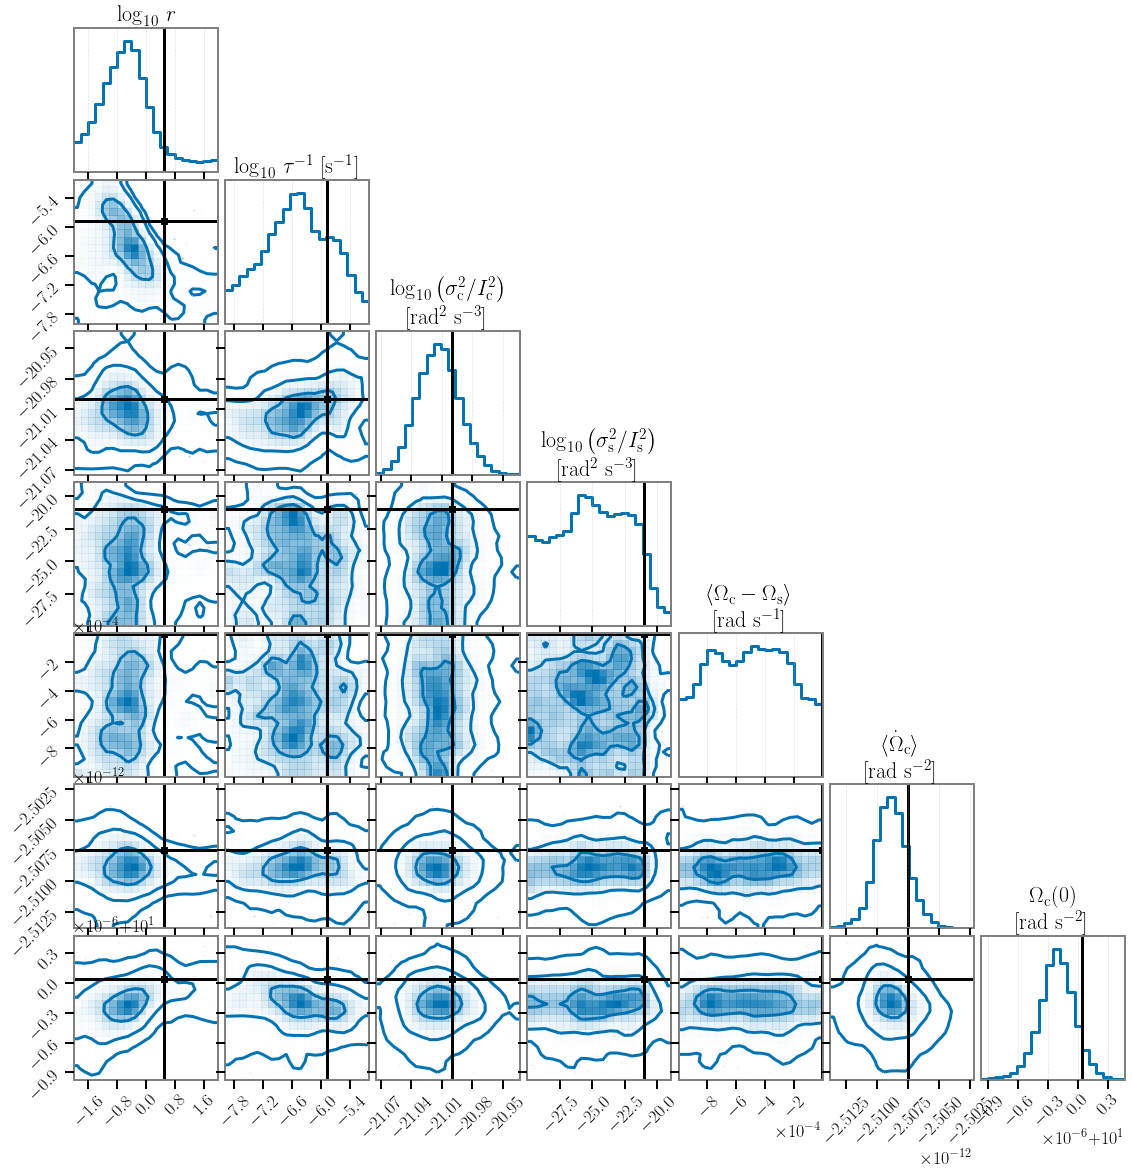

In [8]:
samples3 = result3.posterior.to_numpy()[:, :7].copy()
samples3 = samples3[:, :]
samples3[:, 0] = np.log10(result3.posterior.to_numpy()[:, 0])
samples3[:, 1] = np.log10(result3.posterior.to_numpy()[:, 1])
samples3[:, 2] = np.log10(result3.posterior.to_numpy()[:, 2])
samples3[:, 3] = np.log10(result3.posterior.to_numpy()[:, 3])

labels = ['$\\log_{10}\,r$',
          '$\\log_{10}\,\\tau^{-1}~[\\rm s^{-1}]$',
          '$\\log_{10}\\left(\\sigma_{\\rm{c}}^2/I_{\\rm{c}}^2\\right)$\n$[\\rm{rad^2~s^{-3}}]$',
          '$\\log_{10}\\left(\\sigma_{\\rm{s}}^2/I_{\\rm{s}}^2\\right)$\n$[\\rm{rad^2~s^{-3}}]$',
          '$\\langle\\Omega_{\\rm{c}} - \\Omega_{\\rm{s}}\\rangle$\n$[\\rm{rad~s^{-1}}]$',
          '$\\langle \\dot\\Omega_{\\rm{c}}\\rangle$\n$[\\rm{rad~s^{-2}}]$',
          '$\Omega_{\\rm{c}}(0)$\n$[\\rm{rad~s^{-2}}]$']
#           '$\\log_{10}\,\\rm{EFAC}$',
#           '$\\log_{10}\,\\rm{EQUAD}$']
print(samples3.shape)
fig = corner(samples3, color='C0', smooth=True, smooth1d=True,
             levels=[1-np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9/2)],
            truths=[np.log10(r), -np.log10(tau), np.log10(Qc), np.log10(Qs), lag, omgc_dot, F0_est], truth_color='k')#,
axarr = np.reshape(fig.axes, (len(labels), len(labels)))
for ii, label in enumerate(labels):
    axarr[ii,ii].set_title(label, fontsize=22)
plt.show()